In [1]:
import torch, torchvision
import method
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from skimage.io import imread
from skimage.transform import resize
import os
from PIL import Image

In [2]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()])

In [4]:
def get_batch(valdir, batch_size):
    img_batch = []
    filenames = os.listdir(valdir)
    for fn in filenames[:batch_size]:
        img = Image.open(valdir + fn)
        img = transform(img)
        img = normalize(img)
        img_batch.append(img.numpy())
        
    img_batch = np.array(img_batch)
    
    return img_batch

In [5]:
def get_output_size(model, layer_num, device):
    x = torch.randn(1, 3, 224, 224).to(device)
    hidden_size = model.feature(x, layer_num).shape[0]
    return hidden_size

In [6]:
def compute_sing_vals_vecs(Adot, ATdot, p, q, max_iter):
    x0 = ((np.random.rand(3 * 224**2) - 0.5)/ 255.).astype(np.float64)
    x, s = method.power_method(np.copy(x0), Adot, ATdot, p=p, q=q, max_iter=max_iter)
    return x

In [7]:
def compute_fooling_rates(net, advs, device, valdir):
    filenames = os.listdir(valdir)
    batch_size = 128
    n_steps = len(filenames) // batch_size + 1
    counters = {}
    for j, bsize in enumerate(advs):
        counters[bsize] = 0.
        adv = advs[bsize]
        counter_bad = 0.
        net.eval()
        for i in tqdm(range(n_steps)):
            fn_batch = filenames[i * batch_size : (i + 1) * batch_size]
            cur_batch = []
            cur_batch_pert = []
            for fn in fn_batch:
                cur_img = Image.open(valdir + fn)

                if np.array(cur_img).ndim != 3 or np.array(cur_img).shape[-1] != 3:
                    counter_bad += 1
                    continue

                cur_img = transform(cur_img)
                cur_img_pert = cur_img + adv

                cur_img = normalize(cur_img)
                cur_img_pert = normalize(cur_img_pert)     

                cur_batch.append(cur_img)
                cur_batch_pert.append(cur_img_pert)

            img_batch_tensor = torch.stack(cur_batch).to(device)
            p = method.tonp(net(img_batch_tensor))
            img_batch_pert_tensor = torch.stack(cur_batch_pert).to(device)
            p_pert = method.tonp(net(img_batch_pert_tensor))
            counters[bsize] += np.sum(p.argmax(1) != p_pert.argmax(1))
            
    fooling_rates = {}
    for bsize in counters:
        c = counters[bsize]
        fooling_rates[bsize] = c / (len(filenames) - counter_bad)
        
    return fooling_rates

In [8]:
def plot_fooling_rates(fooling_rates):
    bsizes = list(fooling_rates.keys())
    f_rates = list(fooling_rates.values())
    plt.plot(bsizes, f_rates)
    plt.xlabel('Batch size')
    plt.ylabel('Fooling rate')
    plt.grid()
    plt.title('Dependence of the fooling rate on the batch size')
    plt.show()

In [9]:
def make_exp(net_type, device, layer_num):
    valdir = './imnet/'
    max_iter = 30
    p = np.inf
    q = 5
    # define model
    # net type: vgg16, vgg19 or resnet50
    if net_type == 'vgg16':
        net = torchvision.models.vgg16(pretrained=True)
        net.to(device)
        net.eval()
        model = method.VGGWrapper(net, device)
    elif net_type == 'vgg19':
        net = torchvision.models.vgg19(pretrained=True)
        net.to(device)
        net.eval()
        model = method.VGGWrapper(net, device)
    elif args.model == 'resnet34':
        net = torchvision.models.resnet34(pretrained=True)
        net.to(device)
        net.eval()
        model = method.ResNetWrapper(net, device)
    
    # compute singluar values and vectors
    batch_sizes = [16 * i for i in range(1, 9)]
    advs = {}
    for batch_size in tqdm(batch_sizes):
        img_batch = get_batch(valdir, batch_size=batch_size)
        hidden_size = get_output_size(model, layer_num, device)
        Adot, ATdot = method.get_batched_matvec(img_batch, model, layer_num, hidden_size)
        x = compute_sing_vals_vecs(Adot, ATdot, p, q, max_iter)
        advs[batch_size] = torch.FloatTensor(x.reshape(3, 224, 224) * 10. / 255.)
    
    # make adversarials
    
    # compute fooling rates
    fooling_rates = compute_fooling_rates(net, advs, device, valdir)
    
    # plot fooling rate
    plot_fooling_rates(fooling_rates)
    return fooling_rates

In [ ]:
d = torch.device('cuda')
fooling_rates = make_exp(net_type='vgg19', device=d, layer_num=10)

 50%|█████     | 4/8 [06:05<06:02, 90.67s/it]

In [19]:
fooling_rates

{16: 0.5757026476578412,
 32: 0.6059470468431772,
 48: 0.604704684317719,
 64: 0.599775967413442,
 80: 0.614949083503055,
 96: 0.6197148676171079,
 112: 0.6213645621181263,
 128: 0.6179226069246436}

In [20]:
[16 * i for i in range(1, 9)]

[16, 32, 48, 64, 80, 96, 112, 128]

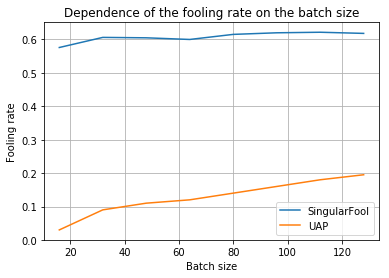

In [30]:
plt.plot(fooling_rates.keys(), fooling_rates.values(), label="SingularFool")
plt.plot(fooling_rates.keys(), [0.03, 0.09, 0.11, 0.12, 0.14, 0.16, 0.18, 0.195], label="UAP")
plt.xlabel('Batch size')
plt.ylabel('Fooling rate')
plt.grid()
plt.title('Dependence of the fooling rate on the batch size')
plt.legend()
plt.savefig("./exp4.png", dpi=300, )